# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

from neo4j import GraphDatabase

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Neo4j connection details

load_dotenv('../KG/db.env')

uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

# Creating a Neo4j Driver Instance
driver = GraphDatabase.driver(uri, auth=(user, password))

# Verifying Connection
try:
    driver.verify_connectivity()
except Exception as err:
    print(f"Error: {err}, type: {type(err)}")

In [3]:
# Define a function to retrieve data from the knowledge graph based on suitable cypher queries 

def retrieve_data_from_graph(query):
    
    result_data = []

    with driver.session() as session:
        result = session.run(query)

        for record in result:
            result_data.append(dict(record))
    
    return result_data

In [4]:
# Function to retrieve all the data for a particular disease

def get_data_of_disease(disease):
    
    # Retrieve data for a specific disease from the knowledge graph.

    # Parameters:
    #     disease_name (str): The name of the disease to retrieve data for.

    # Returns:
    #     disease_df (pd.DataFrame): DataFrame containing person, disease, biomarker, and protein data.
    
    disease_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    RETURN p.respondentId as Respondent_ID,
    d.name AS DiseaseName,
    s.status AS DiseaseStatus;
    """

    disease_df = pd.DataFrame(retrieve_data_from_graph(disease_query))
    disease_data = disease_df.pivot(index=['Respondent_ID'],columns='DiseaseName', values='DiseaseStatus')
    disease_data = disease_data.reset_index()
    disease_data[disease] = disease_data[disease].map({'Negative': 0, 'Positive' : 1})

    biomarker_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodBiomarker)
    RETURN p.respondentId as Respondent_ID,
    p.gender AS Gender,
    p.age AS Age,
    p.bmi AS BMI,
    b.name AS BiomarkerName,
    b.unit AS BiomarkerUnit,
    h.value AS BiomarkerValue;
    """

    biomarker_df = pd.DataFrame(retrieve_data_from_graph(biomarker_query))
    biomarker_df['BloodBiomarker'] = np.where(biomarker_df['BiomarkerUnit'].notnull(),
                                       biomarker_df['BiomarkerName'] + ' [' + biomarker_df['BiomarkerUnit'] + ']',
                                       biomarker_df['BiomarkerName'])
    biomarker_data = biomarker_df.pivot(index=['Respondent_ID','Gender','Age','BMI'], 
                                        columns='BloodBiomarker',
                                        values='BiomarkerValue')
    biomarker_data = biomarker_data.reset_index()
    biomarker_data['Gender'] = biomarker_data['Gender'].map({'Female': 0, 'Male' : 1})


    protein_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodProtein)
    RETURN p.respondentId as Respondent_ID,
    b.name AS ProteinName,
    b.unit AS ProteinUnit,
    h.value AS ProteinValue;
    """

    protein_df = pd.DataFrame(retrieve_data_from_graph(protein_query))
    protein_df['BloodProtein'] = np.where(protein_df['ProteinUnit'].notnull(),
                                       protein_df['ProteinName'] + ' [' + protein_df['ProteinUnit'] + ']',
                                       protein_df['ProteinName'])
    protein_data = protein_df.pivot(index=['Respondent_ID'], 
                                        columns='BloodProtein',
                                        values='ProteinValue')
    protein_data = protein_data.reset_index()

    disease_df = biomarker_data.merge(protein_data, on='Respondent_ID',how='inner')
    disease_df = disease_df.merge(disease_data, on='Respondent_ID',how='inner')
    
    return disease_df

# Diabetes

In [5]:
# Data for Diabetes

diabetes_df = get_data_of_disease('Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


## Pre-processing

In [6]:
# Seperate the attributes and labels

X = diabetes_df.drop(['Respondent_ID','Diabetes'],axis=1)
y = diabetes_df['Diabetes'].copy()

In [7]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [8]:
imputer = SimpleImputer(strategy="mean")

imputer.fit(X_train)

imputer.statistics_     # contains the mean values for each attribute

array([4.94658420e-01, 3.59339331e+01, 2.66632902e+01, 6.69514656e+01,
       1.35202339e+00, 9.39828822e-02, 5.47632135e-02, 2.65182621e+01,
       7.56096753e-01, 1.96819124e-01, 1.46247362e+01, 3.32056939e+00,
       5.17312568e-02, 1.87938976e+02, 5.72086819e+00, 2.36572875e+00,
       6.82204875e+00, 2.02666800e-02, 3.58133427e+00, 4.08380899e+01,
       8.74950411e-01, 2.96303844e+00, 6.19282418e+00, 4.17317981e+00,
       3.08708316e+00, 5.76856497e+00, 4.08877754e+01, 1.63781259e+01,
       8.73197552e+01, 1.54538462e+01, 2.19882788e+00, 3.44511980e-01,
       3.41073393e+01, 3.25265641e+01, 4.47506490e+00, 3.35746563e+01,
       2.90903595e+01, 8.65968362e+01, 8.09436806e+00, 8.20218688e+00,
       1.88218522e+00, 1.26717164e+02, 8.42009284e-02, 2.80846349e+02,
       3.66912199e+00, 2.59371211e+02, 1.17680544e+02, 3.76126934e+01,
       4.09615709e+00, 4.73612722e+00, 1.37733477e+01, 1.71851328e+00,
       5.37858134e-02, 1.99033503e-02, 5.40956925e+01, 1.40336076e+02,
      

In [9]:
X_train = imputer.transform(X_train)

X_train = pd.DataFrame(X_train, columns=X.columns)

# Data with null values imputed with mean
X_train

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,64.0,33.0,97.900000,1.310345,0.259000,0.087000,48.994000,0.4,1.254000,...,1.710000,99.300000,14.000000,14.4,60.840000,4.758000,160.000000,17.000000,31.400000,0.892000
1,0.0,24.0,17.2,26.200000,1.151515,0.037000,0.024000,18.483000,0.8,0.067000,...,1.660000,21.400000,19.000000,12.3,85.300426,2.805636,121.000000,21.000000,36.800000,1.213088
2,1.0,11.0,17.6,76.600000,1.352023,0.077000,0.109000,23.684000,0.4,0.355000,...,1.378027,134.844354,29.777543,15.5,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088
3,1.0,39.0,27.2,54.000000,1.000000,0.009000,0.074000,89.397000,0.5,0.147000,...,0.750000,578.000000,88.000000,16.0,85.300426,2.805636,159.609324,43.000000,24.500000,1.213088
4,1.0,64.0,33.7,79.300000,1.147059,0.028000,0.043000,25.542000,0.8,0.067000,...,1.270000,72.800000,18.000000,13.6,85.300426,2.805636,147.000000,21.000000,44.500000,1.213088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,51.0,25.6,53.900000,1.344828,0.183000,0.052000,19.435000,0.5,0.113000,...,1.630000,109.000000,10.000000,13.8,40.380000,2.069000,136.000000,34.000000,34.800000,1.073000
7110,0.0,53.0,20.3,60.700000,1.400000,0.117000,0.116000,35.294000,1.1,1.012000,...,1.810000,186.000000,49.000000,12.8,85.300426,2.805636,136.000000,21.000000,31.400000,1.213088
7111,0.0,5.0,17.7,70.500000,1.352023,0.093983,0.054763,26.518262,0.7,0.196819,...,1.378027,18.900000,29.777543,12.6,85.300426,2.805636,159.609324,26.935729,44.600000,1.213088
7112,0.0,77.0,27.9,66.951466,1.352023,0.093983,0.054763,26.518262,0.9,0.196819,...,1.378027,134.844354,29.777543,16.3,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088


In [10]:
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [11]:
y_train

7481    1
2022    0
3847    0
5980    0
1928    1
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: Diabetes, Length: 7114, dtype: int64

In [12]:
# Scaling the data

X_train_gender = X_train.Gender
X_train = X_train.drop('Gender',axis=1)
X_test_gender = X_test.Gender
X_test = X_test.drop('Gender',axis=1)
cols = X_train.columns

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train.insert(0, "Gender", X_train_gender)
X_test.insert(0, "Gender", X_test_gender)

In [13]:
X_train

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,1.121311,0.812589,1.165805,-0.205686,1.075311,1.187386,2.600011,-1.169116,5.368648,...,9.955759e-01,-2.211773e-01,-4.323034e-01,0.472350,-3.946538e-01,3.832557e+00,0.013746,-1.028823,-0.473985,-5.216751e-01
1,0.0,-0.476791,-1.213527,-1.535073,-0.989521,-0.371321,-1.133110,-0.929526,0.144141,-0.659256,...,8.456278e-01,-7.059155e-01,-2.953038e-01,-1.033425,-2.292833e-16,-8.717621e-16,-1.358517,-0.614632,-0.191538,3.607582e-16
2,1.0,-0.996174,-1.162233,0.363452,0.000000,-0.110667,1.997718,-0.327870,-1.169116,0.803285,...,6.659036e-16,-1.768561e-16,9.734406e-17,1.261090,-2.292833e-16,-8.717621e-16,0.000000,0.000000,0.000000,3.607582e-16
3,1.0,0.122497,0.068825,-0.487871,-1.737258,-0.553779,0.708554,7.273863,-0.840802,-0.252995,...,-1.883429e+00,2.757567e+00,1.595290e+00,1.619608,-2.292833e-16,-8.717621e-16,0.000000,1.663420,-0.834888,3.607582e-16
4,1.0,1.121311,0.902354,0.465159,-1.011513,-0.429968,-0.433278,-0.112935,0.144141,-0.659256,...,-3.239679e-01,-3.860754e-01,-3.227037e-01,-0.101278,-2.292833e-16,-8.717621e-16,-0.443675,-0.614632,0.211209,3.607582e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,0.601928,-0.136351,-0.491638,-0.035512,0.580067,-0.101778,-0.819397,-0.840802,-0.425656,...,7.556589e-01,-1.608183e-01,-5.419030e-01,0.042129,-7.247632e-01,-1.446041e+00,-0.830723,0.731490,-0.296148,-2.276025e-01
7110,0.0,0.681833,-0.815998,-0.235487,0.236768,0.149988,2.255551,1.015184,1.129083,4.139707,...,1.295472e+00,3.183196e-01,5.266937e-01,-0.674907,-2.292833e-16,-8.717621e-16,-0.830723,-0.614632,-0.473985,3.607582e-16
7111,0.0,-1.235890,-1.149409,0.133670,0.000000,0.000000,0.000000,0.000000,-0.184174,0.000000,...,6.659036e-16,-7.214720e-01,9.734406e-17,-0.818314,-2.292833e-16,-8.717621e-16,0.000000,0.000000,0.216440,3.607582e-16
7112,0.0,1.640695,0.158590,0.000000,0.000000,0.000000,0.000000,0.000000,0.472455,0.000000,...,6.659036e-16,-1.768561e-16,9.734406e-17,1.834718,-2.292833e-16,-8.717621e-16,0.000000,0.000000,0.000000,3.607582e-16


In [14]:
y_train

7481    1
2022    0
3847    0
5980    0
1928    1
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: Diabetes, Length: 7114, dtype: int64

### Pipeline for Pre-processing

In [15]:
# We can define a function to do all the preprocessing and the splitting of data

def preprocess_and_split(df, label, impute=True, impute_strategy = 'mean', test_size=0.2, random_state=42):
    
    # Preprocesses the input dataframe and splits it into training and testing sets.

    # Parameters:
    #     df (DataFrame): The input dataframe.
    #     label (str): The column name for the target variable.
    #     test_size (float): The proportion of the dataset to include in the test split.
    #     random_state (int): Random seed for reproducibility.
    #     impute (bool): Whether to impute missing values.

    # Returns:
    #     X (DataFrame): The feature matrix.
    #     y (DataFrame): The target values.
    #     X_train (DataFrame): The training feature matrix.
    #     X_test (DataFrame): The testing feature matrix.
    #     y_train (Series): The training target values.
    #     y_test (Series): The testing target values.
    
    imputer = SimpleImputer(strategy=impute_strategy)
    scaler = StandardScaler()
    
    X = df.drop(['Respondent_ID',label], axis=1)
    if impute==True:
        cols = X.columns
        X = imputer.fit_transform(X)
        X = pd.DataFrame(X, columns=cols)
    y = df[label].copy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Separate categorical and numerical columns 
    categorical_cols = ['Gender'] 
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Preprocessing for numerical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')) if impute else ('imputer', 'passthrough'),
        ('scaler', StandardScaler())])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')) if impute else ('imputer', 'passthrough')])
    
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numeric_transformer, numeric_cols)])
    
    # Preprocess data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # Convert back to DataFrames
    X_train = pd.DataFrame(X_train, columns= categorical_cols + numeric_cols)
    X_test = pd.DataFrame(X_test, columns= categorical_cols + numeric_cols)
    
    return X, y, X_train, X_test, y_train, y_test

In [16]:
# Attributes and Labels

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes', impute = True)

In [17]:
X_train

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,1.121311,0.813694,1.166042,-0.206059,1.077684,1.185437,2.599330,-1.168580,5.367807,...,0.993507,-0.218923,-0.431586,0.473963,-0.396556,3.811852,0.013100,-1.028802,-0.475109,-0.529949
1,0.0,-0.476791,-1.212410,-1.534836,-0.989893,-0.368938,-1.135046,-0.930205,0.144676,-0.660092,...,0.843560,-0.703658,-0.294587,-1.031801,0.000805,0.008646,-1.359163,-0.614611,-0.192663,0.003528
2,1.0,-0.996174,-1.161116,0.363689,0.000743,-0.108285,1.995765,-0.328549,-1.168580,0.802448,...,0.006532,-0.006553,-0.001429,1.262697,0.000805,0.008646,0.001207,-0.000041,0.003236,0.003528
3,1.0,0.122497,0.069934,-0.487634,-1.737630,-0.551394,0.706607,7.273178,-0.840266,-0.253831,...,-1.885478,2.759800,1.596006,1.621212,0.000805,0.008646,0.001207,1.663441,-0.836012,0.003528
4,1.0,1.121311,0.903458,0.465396,-1.011885,-0.427584,-0.435218,-0.113614,0.144676,-0.660092,...,-0.326028,-0.383820,-0.321987,-0.099661,0.000805,0.008646,-0.444321,-0.614611,0.210084,0.003528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,0.601928,-0.135241,-0.491401,-0.035884,0.582444,-0.103720,-0.820077,-0.840266,-0.426492,...,0.753592,-0.158564,-0.541186,0.043745,-0.726665,-1.466281,-0.831369,0.731510,-0.297272,-0.235881
7110,0.0,0.681833,-0.814883,-0.235250,0.236395,0.152368,2.253597,1.014504,1.129618,4.138867,...,1.293401,0.320570,0.527410,-0.673286,0.000805,0.008646,-0.831369,-0.614611,-0.475109,0.003528
7111,0.0,-1.235890,-1.148293,0.133907,0.000743,-0.005723,0.005289,0.002043,-0.183638,0.002284,...,0.006532,-0.719214,-0.001429,-0.816692,0.000805,0.008646,0.001207,-0.000041,0.215314,0.003528
7112,0.0,1.640695,0.159699,-0.001203,0.000743,-0.005723,0.005289,0.002043,0.472990,0.002284,...,0.006532,-0.006553,-0.001429,1.836321,0.000805,0.008646,0.001207,-0.000041,0.003236,0.003528


In [18]:
y_train

7481    1
2022    0
3847    0
5980    0
1928    1
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: Diabetes, Length: 7114, dtype: int64

## Feature Selection

### Correlation Analysis

In [19]:
# Function to check which features are more correlated with the disease

def get_correlated_features(df,disease,pos,neg):
    
    corr_df = df.corr()[disease].sort_values(ascending=False)
    pos_corr = corr_df[corr_df>pos]
    neg_corr = corr_df[corr_df<neg]
    
    return pos_corr, neg_corr

In [20]:
pos_corr, neg_corr = get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

print('Positive Correlation\n\n',pos_corr,sep='')
print('\n\nNegative Correlation\n\n',neg_corr,sep='')

Positive Correlation

Diabetes                              1.000000
Glycohemoglobin [%]                   0.616415
Fasting Glucose [mmol/L]              0.610611
Age                                   0.396039
BMI                                   0.269706
Blood Urea Nitrogen [mg/dL]           0.242561
Insulin [pmol/L]                      0.234273
Osmolality [mmol/Kg]                  0.224238
Retinol [umol/L]                      0.213473
Triglyceride [mmol/L]                 0.167136
Alpha-tocopherol [umol/L]             0.162476
Triglyceride_HDL Ratio                0.156951
Segmented neutrophils [%]             0.153802
Neutrophil_Lymphocyte Ratio           0.147970
C-Reactive Protein [mg/L]             0.137446
Creatinine [mg/dL]                    0.132612
Ferritin [ng/mL]                      0.130874
Red cell distribution width [%]       0.124067
25-hydroxyvitamin D2 + D3 [nmol/L]    0.104823
Total Cholestrol_HDL Ratio            0.104507
Mean platelet volume [fL]             

### SelectKBest

In [21]:
# Function to select features using SelectKBest using anova scores

def select_k_best(df,disease,n):
    
    imputer = SimpleImputer(strategy='mean')
    
    select = SelectKBest(score_func = f_classif, k = n)

    x = df.drop(['Respondent_ID',disease],axis=1)
    y = df[disease].copy()
    X = imputer.fit_transform(x)
    
    z = select.fit_transform(X,y)

    filtered = select.get_support()
    features = np.array(x.columns)
    
    return features[filtered]

In [22]:
anova_features = select_k_best(diabetes_df,'Diabetes',n=15)
anova_features

array(['Age', 'BMI', 'Alpha-crypotoxanthin [umol/L]',
       'Alpha-tocopherol [umol/L]', 'Blood Urea Nitrogen [mg/dL]',
       'Fasting Glucose [mmol/L]', 'Glycohemoglobin [%]',
       'Lymphocyte [%]', 'Lymphocyte_C-Reactive Protein Ratio',
       'Neutrophil_Lymphocyte Ratio', 'Osmolality [mmol/Kg]',
       'Retinol [umol/L]', 'Segmented neutrophils [%]', 'Albumin [g/dL]',
       'Insulin [pmol/L]'], dtype=object)

## Model Training and Evaluation

### Logistic Regression

In [23]:
log_reg = LogisticRegression()

In [24]:
# Training

log_reg.fit(X_train, y_train)

# Accuracy scores

y_pred = log_reg.predict(X_test)

print('Training Accuracy: ',accuracy_score(y_train, log_reg.predict(X_train)))

print('Testing Accuracy: ',accuracy_score(y_test, y_pred))

Training Accuracy:  0.9380095586168119
Testing Accuracy:  0.9432265317594154


In [25]:
# Confusion matrix

print(confusion_matrix(y_test, y_pred))

[[1538   25]
 [  76  140]]


In [26]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1563
           1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779



In [27]:
# Function for model evaluation

def evaluate_model_metrics(model,X_train,y_train,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'\nTrain Accuracy: {train_accuracy:.3f}')
    print(f'\nTest Accuracy: {test_accuracy:.3f}')

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f'\nPrecision: {precision:.3f}')

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f'\nRecall: {recall:.3f}')

    # F1-score
    f1 = f1_score(y_test, y_pred)
    print(f'\nF1-Score: {f1:.3f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n')
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print('\n\nClassification Report:\n')
    print(class_report)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print('\nROC-AUC Curve:')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


Train Accuracy: 0.938

Test Accuracy: 0.943

Precision: 0.848

Recall: 0.648

F1-Score: 0.735

Confusion Matrix:

[[1538   25]
 [  76  140]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


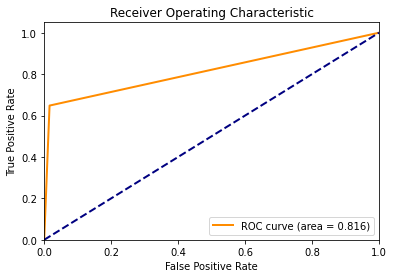

In [28]:
evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Hyperparameter Optimization

In [29]:
# It is the process of finding the right combination of hyperparameter values 
# to achieve maximum performance on the data in a reasonable amount of time

### Grid Search

In [30]:
# Grid search is an exhaustive method to find optimal values for hyperparameters

# Hyperparameters
param_grid = {
    
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','saga','lbfgs'],
    'max_iter': [100,200,300],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True],
    
}

In [31]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

clear_output()     # to clear warnings

In [32]:
# Best hyperparameters
grid_best_params = grid_search.best_params_
grid_best_params

{'C': 0.1,
 'class_weight': None,
 'max_iter': 200,
 'penalty': 'l1',
 'solver': 'saga',
 'warm_start': False}

In [33]:
# Model with the best hyperparameters
log_reg_grid = grid_search.best_estimator_


Train Accuracy: 0.939

Test Accuracy: 0.946

Precision: 0.870

Recall: 0.653

F1-Score: 0.746

Confusion Matrix:

[[1542   21]
 [  75  141]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97      1563
     Class 1       0.87      0.65      0.75       216

    accuracy                           0.95      1779
   macro avg       0.91      0.82      0.86      1779
weighted avg       0.94      0.95      0.94      1779


ROC-AUC Curve:


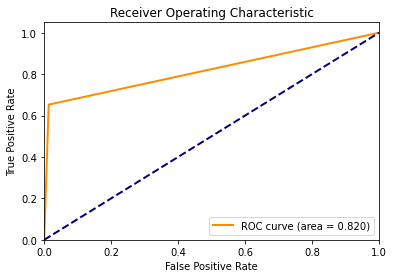

In [34]:
evaluate_model_metrics(log_reg_grid,X_train,y_train,X_test,y_test)

# We can see a slight improvement in some evaluation metrics

In [35]:
# Function to perform grid search optimisation

def grid_search_optimize(model, param_grid, cv, X_train, y_train, scoring='accuracy', verbose=0, n_jobs=-1):
    
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, 
                               scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    grid_search.fit(X_train, y_train)
    clear_output()
    
    grid_best_params = grid_search.best_params_
    grid_best_model = grid_search.best_estimator_
    
    return grid_best_params, grid_best_model

### Random Search

In [36]:
# Random Search is faster than grid search due to less iterations performed but it may not be optimal 

random_search = RandomizedSearchCV(
        log_reg,
        param_distributions=param_grid,
        n_iter=100, 
        scoring='accuracy', 
        cv=5, 
        n_jobs=-1, 
        verbose=0
    )

random_search.fit(X_train, y_train)

clear_output()

In [37]:
rand_best_params = random_search.best_params_
rand_best_params

# We get similar hyperparameters

{'warm_start': False,
 'solver': 'saga',
 'penalty': 'l1',
 'max_iter': 200,
 'class_weight': None,
 'C': 0.1}

In [38]:
# Function for Random Search

def random_search_optimize(model,param,n_iter,X_train, y_train,cv,scoring='accuracy', n_jobs=-1, verbose=0):
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param,
        n_iter=n_iter, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=n_jobs, 
        verbose=verbose
    )

    random_search.fit(X_train, y_train)
    clear_output()

    rand_best_params = random_search.best_params_
    rand_best_model = random_search.best_estimator_
    
    return rand_best_params, rand_best_model

### Cross Validation

In [39]:
# It is a technique used to evaluate the performance of a model on unseen data.
# It involves dividing the available data into multiple folds or subsets, 
# using one of these folds as a validation set, and training the model on the remaining folds.

### K-fold

In [40]:
# The dataset is divided into k subsets or folds. 
# The model is trained and evaluated k times, using a different fold as the validation set each time. 
# Performance metrics from each fold are averaged to estimate the model's generalization performance.

scores = cross_val_score(log_reg_grid, X, y, cv=10, scoring='accuracy')

print("Scores:", scores)

Scores: [0.87078652 0.87752809 0.87191011 0.87514061 0.87514061 0.86839145
 0.87401575 0.86951631 0.86951631 0.87626547]


In [41]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print("\nMean Accuracy: ", mean_accuracy)
print("\nStandard Deviation: ", std_accuracy)


Mean Accuracy:  0.8728211220788413

Standard Deviation:  0.003043703572477998


In [42]:
def k_cross_validate(model,X,y,cv,scoring='accuracy',n_jobs=-1):
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"\n{scoring} scores:", scores)
    print(f"\nMean {scoring} score: ", mean_score)
    print("\nStandard deviation: ", std_score)

In [43]:
k_cross_validate(log_reg_grid,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.87078652 0.87752809 0.87191011 0.87514061 0.87514061 0.86839145
 0.87401575 0.86951631 0.86951631 0.87626547]

Mean accuracy score:  0.8728211220788413

Standard deviation:  0.003043703572477998
